In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

In [176]:
class CircularBuffer(deque):

    def push(self, x):
        self.appendleft(x)
        self.pop


class DerivateSignal():
    """ Just push() values into the signal and easily access to its previous states and derivatives
        by accesing directly into the objets in the form: obj[n_previous, n_derivative]
        Examples:
            actual_value = signal[0, 0]
            previous_value = signal[1, 0]
            actual_first_derivative = signal[0, 1]
            previous_second_derivative = signal[1, 2]
    """
    def __init__(self, initial_value):
        self.buffer = CircularBuffer([initial_value] * 6)
        self.derivatives = (self.D0, self.D1, self.D2)

    def push(self, value):
        self.buffer.push(value)

    def D0(self, t):
        return self.buffer[0 + t]

    def D1(self, t):
        return self.buffer[0 + t] - self.buffer[1 + t]

    def D2(self, t):
        return self.buffer[0 + t] - 2 * self.buffer[1 + t] + self.buffer[2 + t]

    def __getitem__(self, tup):
        t, Dn = tup
        return self.derivatives[Dn](t)
    
def clamp(x, maxmin):
    return max(min(maxmin, x), -maxmin)

## Definition

Let $x[t]$ be our target signal, and $y[t]$ the signal that is $x[t]$ smoothed

let $n$ be a interger number ranging from $0$ to $+\infty$

$y_{1}[t]$ will be a signal that for any time before $t_{0}$ is equal to $y[t]$, but from $t_{0}$ is equal to $x[t]$. So we can state:

* $y_{1}[t_{0} + n] = x[t_{0} + n]$


* $y_{1}[t_{0} - 1 - n] = y[t_{0} - 1 - n]$


* $y_{1}'[t_{0}] = y_{1}[t_{0}] - y_{1}[t_{0} - 1]$

  $\Leftrightarrow y_{1}'[t_{0}] = x[t_{0}] - y[t_{0} - 1]$ for $n = 0$


* $y_{1}''[t_{0}] = y_{1}'[t_{0}] - y_{1}'[t_{0} - 1]$

  $\Leftrightarrow y_{1}''[t_{0}] = (x[t_{0}] - y[t_{0} - 1]) - ( y[t_{0}-1] - y[t_{0} - 2])$
  
  $\Leftrightarrow y_{1}''[t_{0}] = x[t_{0}] - 2y[t_{0} - 1] + y[t_{0} - 2]$

Now $y_{1}''[t_{0}]$ is equal to the second derivative that must have $y[t]$ to perfectly fit $x[t]$ at any moment $t$.

If we want $y[t]$ to follow $x[t]$ in a way that the absolute value of second derivative of $y[t]$ be equal or less that a value $a$ then we can make $t = t_{0}$ and $y''[t] = \min (\max (y_{1}''[t_{0}], -a), a)$. This will make $y[t]$ "accelerate" to where $x[t]$ is, **but it will not "break" early enough to stop on $x[t]$, instead it will overshoot and resonate.**

Now we have to define $y[t]$ in terms of $y''[t]$:
$$y'[t] = y[t] - y[t - 1]$$
$$\Leftrightarrow y''[t] = y'[t] - y'[t - 1]$$
$$\Leftrightarrow y''[t] = (y[t] - y[t - 1]) - y'[t - 1]$$
$$\Leftrightarrow y[t] = y''[t] + y[t - 1] + y'[t - 1]$$
Replacing $y''[t]$ by $\min (\max (y_{1}''[t_{0}], -a), a)$ and $t_{0}$ by $t$:
$$\Leftrightarrow y[t] = \min (\max (y_{1}''[t], -a), a) + y[t - 1] + y'[t - 1]$$
Expanding $y_{1}''[t]$ with the ecuation abobe:
$$\Leftrightarrow y[t] = \min (\max (x[t_{0}] - 2y[t_{0} - 1] + y[t_{0} - 2], -a), a) + y[t - 1] + y'[t - 1]$$

## Example in action

In python replaced $\min (\max (x, -a), a)$ with `clamp(x, a)` and for the example below also made the variable `y_2nd_derivative` which makes the formula abobe more readable

In [177]:
x = ([0,] * 20) + ([1,] * 130) # 20 zeroes followed by 130 ones
a = 0.01 # 

In [188]:
def smooth_and_plot(x, a):
    y_rt = DerivateSignal(0)
    # x_rt = DerivateSignal(x[0])
    y= []

    for xt in x:
        # x_rt.push(xt)
        # y_rt.push(clamp(xt - (2 *y_rt[0, 0] - y_rt[1, 0]), a) + 2 * y_rt[0, 0] - y_rt[1, 0])
        y_2nd_derivative = xt - (2 *y_rt[0, 0] - y_rt[1, 0])
        y_rt.push(clamp(y_2nd_derivative, a) + y_rt[0, 0] + y_rt[0, 1])
        y.append(y_rt[0, 0])

    plt.plot(x)
    plt.plot(y)
    plt.legend(['x[t]', 'y[t]'])

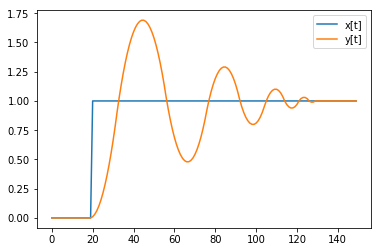

In [191]:
smooth_and_plot(x, a)

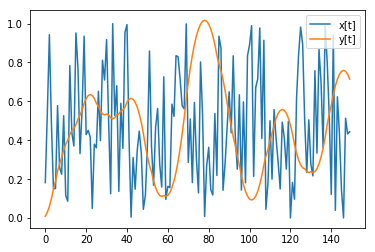

In [198]:
smooth_and_plot(np.random.rand(150), a) # the same but with a random x[t]